# <center>chap8. Dimensionality Reduction</center>
---

In [1]:
# Common imports
import os
import sys
import time
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 0.25.3
scikit-learn version: 0.22.1


**<font color='crimson'>curse of dimensionality:</font>**
+ make training extremely slow


+ make training much harder to find a good solution

<br>

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably (相当地、非常地), turning an intractable (棘手的) problem into a tractable (异处理的) one. 

> **<font color='blue'>Examples:</font> the MNIST images.**
> + the pixels on the image borders are almost always white, so you can completely drop these pixels from the training set without losing much info.
> + two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g., take the mean of the two pixel intensities), you will not loss much info.

**<font color='crimson'>dimensionality reduction:</font>**

+ it will **speed up training**.


+ it **does cause some information loss**, so it **may reduce the system's performance**. In some cases, it may filter out some noise and unnecessary details, and this will result in higher performance, but in general it won't.


+ it **make the pipelines a bit more complex and thus harder to maintain**.


+ it's extremely useful for data visualization (or *DataViz*).


+ you should **first try to train the system with original data** before consider using dimensionality reduction.


**<font color='crimson'>data visualization (DataViz):</font>**

+ Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.


+ DataViz is essential to communicate your conclusions to people who are not data scientists.

# 1. The curse of dimensionality

![0D-to-4D-hypercubes](./figs/chap08-figs/0D-to-4D-hypercubes.png)
<center>Point, segment, square, cube and tesseract (立方体的 4 维模型、超正方体) <b>0D to 4D hypercubes</b></center>

**<font color='crimson'>It turns out that many things behave very differently in high-dimensional space.</font>**

+ If you pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension). But in a 10,000-dimensional unit hypercube, this probability is greater than 99.999999%. **<font color='blue'>Most points in a high-dimensional hypercube are very close to the border</font>**.


+ If you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But if you pick two points picked randomly in a 1,000,000-dimensional hypercube, the average distance will be about 408.25 (roughly $\sqrt{1000000/6}$)! **<font color='blue'>There's just plenty of space in high dimensions, high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other</font>**. This also means that **a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions**, since they will be based on much larger extrapolations (推断). In short, **<font color='blue'>the more dimensions the training set has, the greater the risk of overfitting it.</font>**

**In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.** With just 100 features (significantly fewer than in the MNIST problem), you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

# 2. Main approaches for dimensionality reduction

**<font color='crimson'>two main approaches to reducing dimesionality:</font>**

+ **projection**


+ **Mainfold learning**

## 2.1 Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (such as MNIST). As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

![3D-dataset-close-to-a-2D-subspace](./figs/chap08-figs/3D-dataset-close-to-a-2D-subspace.png)

<center> A 3D dataset lying close to a 2D subspace</center>

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. We will get the new 2D dataset if we project every training instance perpendicularly (垂直地) onto this subspace.

![new-2D-dataset-after-projection](./figs/chap08-figs/new-2D-dataset-after-projection.png)
<center>The new 2D dataset after projection</center>

> The axes correspond to new features z1 and z2 (the coordinates of the projections on the plane).

**<font color='crimsion'>Projection is not always the best approach to dimensionality reduction.</font>** In many cases, the subspace may twist and turn, such as the **Swiss roll toy** dataset.

![swiss-roll-dataset](./figs/chap08-figs/swiss-roll-dataset.png)
<center>Swiss roll dataset</center>

Simply projecting onto a plane (e.g., by dropping x3) would squash(压扁、挤扁) different layers of the Swiss roll together (left figure). What you really want is to unroll the Swiss roll to obtain the 2D dataset on the right figure.

![swiss-roll-dataset-dimensionality-reduced](./figs/chap08-figs/swiss-roll-dataset-dimensionality-reduced.png)

<center>Squash (压扁) by projection onto a plane (left) v.s. unroll the Swiss roll (right)</center>

## 2.2 Mainfold learning

**The Swiss roll is an example of a 2D manifold**.

Put simply, **<font color='crimson'>a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space</font>**. More generally, **<font color='crimson'>a d-dimensional manifold is a part of an n-dimensional space (d < n) that locally resembles a d-dimensional hyperplane</font>**.

Here, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

**<font color='red'>Manifold Learning:</font>** Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie. **<font color='crimson'>It relies on the manifold assumption.</font>**


**<font color='red'>manifold assumption/hypothesis</font> holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.** This assumption is very often empirically observed.

> **<font color='blue'>Example:</font>** MNIST images have some similarities - they are made of connected lines, the borders are white, and they are more or less centered. If you randomly generated images, only a ridiculously (令人惊奇地) tiny (微小的) fraction of them would look like handwritten digits. In other words, the degrees of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted. **These constraints tend to squeeze the dataset into a lower-dimensional manifold**.

**The manifold assumption is often accompanied by <font color='crimson'>another implicit assumption - the task at hand will be simpler if expressed in the lower-dimensional space of the manifold.</font>** However, this implicit assumption does not always hold.

> **<font color='blue'>Example:</font>** in the bottom row of figure, the decision boundary is located at x1 = 5. This decision boundary looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a collection of four independent line segments).

![lower-dimesion-performance](./figs/chap08-figs/lower-dimesion-performance.png)

<center>The decision boundary may not always be simpler with lower dimensions</center>

<br>

In short, **<font color='crimson'>reducing the dimensionality of the training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.</font>**

# 3. PCA

**<font color='red'>Principal Component Analysis (PCA)</font>** is by far the most popular dimensionality reduction algo.

+ First, it identifies the hyperplane that lies closest to the data


+ Then, it projects the data onto it.

## 3.1 Preserve the variance

**First, you need to choose the right hyperplane.**

**<font color='blue'>Example:</font>** a simple 2D dataset is represented on the left along with 3 different axes (i.e., 1D hyperplanes). The right is the result of the projection of the dataset onto each of these axes.

![select-the-subspace-to-project-on](./figs/chap08-figs/select-the-subspace-to-project-on.png)

+ the projection onto the solid line preserves the maximum variance


+ the projection onto the dotted line preserves very little variance


+ the projection onto the dashed line preserves an intermediate amount of variance

**<font color='blue'>It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections.</font>**

Another way to **justify this choice** is that **it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis**. This is the rather simple idea behind PCA.

## 3.2 Principal components

PCA identifies the axis that **accounts for the largest amount of variance in the dataset** (here, the solid line).

It also finds a **second axis**, **orthogonal(正交的) to the first one**, that accounts for the largest amount of remaining variance.

PCA would also find **a third axis**, **orthogonal to both previous axes**, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.


The $i^{th}$ axis is called the $i^{th}$ **<font color='crimson'>principal component (PC)</font>** of the data. Here, the first PC is the axis on which vector $c_1$ lies, and the second PC is the axis on which vector $c_2$ lies.

In the figure, the first two PCs are the orthogonal axes on which the two arrows lie, on the plane, and the 3rd PC is the axis orthogonal to that plane.

<br>

<div class='alert alert-block alert-info'>
    <center><b>Note</b></center>
    For each PC, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing (方向相反的） unit vectors lie on the same axis, <b>the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors</b>. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are close), but the plane they define will generally remain the same.
</div>

**<font color='crimson' size=4>How to find the PCs of a dataset?</font>**

Use a standard matrix factorization technique called **<font color='crimson'>SVD (Singular Value Decomposition)</font>**. It can decompose the data $X$ into the matrix multiplication.

$$X = U Σ V^T$$

**V contains the unit vectors that define all the PCs that we are looking for.** (V 中的列代表一个PC，列数等于特征数)

In [3]:
def build_3d_dataset():
    np.random.seed(4)
    m = 60
    w1, w2 = 0.1, 0.3
    noise = 0.1

    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    X = np.empty((m, 3))
    X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

    return X

In [4]:
X = build_3d_dataset()
X.shape

(60, 3)

In [5]:
X_centered = X - X.mean(axis=0)
# use SVD to obtain all PCs of the data
U, s, Vt = np.linalg.svd(X_centered)

X_centered.shape, U.shape, s.shape, Vt.shape

((60, 3), (60, 60), (3,), (3, 3))

In [6]:
# the first two PCs
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

## 3.3 Project down to d dimensions

**Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions** by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.


To **<font color='blue'>project the dataset</font>** onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the dataset matrix $X$ by the matrix $W_d$, defined as the matrix containing the first d columns of $V$.

$$X_{d-proj}=XW_d$$

In [7]:
# project to dataset onto the plane defined by the first two PCs
W2 = Vt.T[:, :2]  # shape: (3, 2)
X2D_using_svd = X_centered.dot(W2)  # shape: (60, 2)

W2.shape, X2D_using_svd.shape

((3, 2), (60, 2))

## 3.4 Use Sklearn

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2,
          copy=True,  # default, If `False`, data passed to fit are overwritten
          whiten=False,  # default
          svd_solver='auto')  # default
# `PCA` takes care of mean centering.
X2D = pca.fit_transform(X)

In [10]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [11]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

**<font color='blue'>Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped (翻转).</font>** Here, PCA using sklearn gives the same projection as the one given by the SVD approach, except both axes are flipped.

In [12]:
np.allclose(X2D, -X2D_using_svd)

True

In [13]:
# Principal axes in feature space, representing the directions of maximum variance in the data.
# The components are sorted by `explained_variance_`.
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [14]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

## 3.5 Explained variance ratio

**<font color='crimson'>The ratio indicates the proportion of the dataset’s variance that lies along each principal component.</font>**

In [15]:
# The amount of variance explained by each of the selected components.
pca.explained_variance_

array([0.77830975, 0.1351726 ])

In [16]:
# Percentage of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [17]:
0.77830975 / 0.84248607 * 0.14631839

0.13517259643391197

> This tells that 84.2% of the dataset's variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

In [18]:
# This was loss of info during projection
X_inversed = pca.inverse_transform(X2D)
np.allclose(X, X_inversed)

False

## 3.6 Choose the right number of dimensions

**Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%)**. Unless you are reducing dimensionality for data visualization.

+ **<font color='green'>Way 1:</font>**

In [19]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839, 0.01119554])

In [21]:
np.cumsum(pca.explained_variance_ratio_)

array([0.84248607, 0.98880446, 1.        ])

In [22]:
# preserve 96% of the dataset's variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)+1
d

2

+ **<font color='green'>Way 2:</font>**

**You can set `n_components` to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve.**

In [23]:
pca = PCA(n_components=0.95)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [25]:
X_reduced = pca.transform(X)
X_reduced[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [26]:
X_centered.dot(pca.components_.T)[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

+ **<font color='green'>Way 3:</font>**

**Plot the explained variance as a function of the number of the number of dimensions.** There will usually be an elbow in the curve, where the explained variance stops growing fast.

## 3.7 PCA for compression

After dimensionality reduction, the dataset takes up much less space.

In [27]:
from sklearn.datasets import fetch_openml

In [28]:
mnist = fetch_openml('mnist_784', version=1)
x = mnist['data']
y = mnist['target']

y = y.astype(np.int8)
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [29]:
# apply PCA to MNIST while preserve 95% of its variance
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

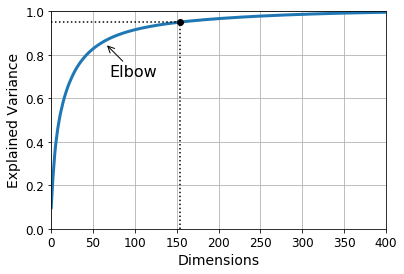

In [30]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], 'k:')
plt.plot([0, d], [0.95, 0.95], 'k:')
plt.plot(d, 0.95, 'ko')
plt.annotate('Elbow', xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle='->'), fontsize=16)
plt.grid(True)
plt.show()

> Each instance only have 254 features, the dataset is now less than 20% of its original size. This is a reasonable compression ratio, and you can see how this size reduction can speed up a classification algorithm tremendously.

It's also **possible to decompress the reduced dataset back** to 784 dimensions, but this **won't give you back the original data**, since **the projection lost a bit of information** (within the 5% variance that was dropped), but it will likely be close to the original data.

$$X_{recovered}=X_{d-proj}W_d^T$$

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the **<font color='red'>reconstruction error</font>**.

In [31]:
pca = PCA(n_components=0.95)
pca.fit(x_train)
x_train_reduced = pca.transform(x_train)
x_train_reduced.shape[1]

154

In [32]:
x_train_recovered = pca.inverse_transform(x_train_reduced)

In [33]:
np.allclose(x_train, x_train_recovered)

False

In [47]:
from sklearn.metrics import mean_absolute_error

In [48]:
mean_absolute_error(x_train, x_train_recovered)

7.975784510726733

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

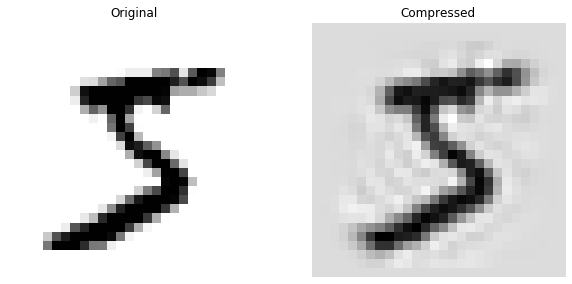

In [36]:
plt.figure(figsize=(10, 4.8))
plt.subplot(121)
plot_digit(x_train[0])
plt.title('Original')
plt.subplot(122)
plot_digit(x_train_recovered[0])
plt.title('Compressed')
plt.show()

## 3.8 Randomized PCA

If you use `PCA(svd_solver='randomized')`, sklearn uses a stochastic algorithm called **<font color='crimson'>Randomized PCA</font>** that **quickly finds an approximation of the first d principal components**. Its computational complexity is $O(m\times d^2)+O(d^3)$, instead of $O(m\times n^2)+O(n^3)$ for the full SVD approach, so it is dramatically **faster** than full SVD when d is much smaller than n.

In [37]:
# n_components must be between 1 and min(n_samples, n_features)
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
x_reduced_rnd = rnd_pca.fit_transform(x_train)

**By default, `PCA()` argument `svd_solver` is actually set to 'auto'**: it automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the `svd_solver` hyperparameter to `'full'`.

## 3.9 Incremental PCA

The above implementations of PCA require the whole dataset set to fit in memory in order for the algorithm to run.

**<font color='crimson'>Incremental PCA (IPCA)</font>** allow you to split the dataset into mini-batches and feed an IPCA algorithm one mini-batch at a time.


+ useful for large dataset


+ useful for applying PCA online (i.e., on the fly, as new instance arrive)

In [38]:
from sklearn.decomposition import IncrementalPCA

+ **<font color='green'>way 1:</font>**

In [39]:
# split the dataset into 100 mini-batches
n_batches = 100
data_batches = np.array_split(x_train, n_batches)

inc_pca = IncrementalPCA(n_components=154)
for x_batch in data_batches:
    # must call the `partial_fit()` with each mini-batch
    inc_pca.partial_fit(x_batch)

x_reduced_inc = inc_pca.transform(x_train)

+ **<font color='green'>way 2:</font>**

In [40]:
# first: create the `memmap()` structure and copy the MNIST data into it
filename = "./datasets/my_mnist.data"
m, n = x_train.shape

x_mm = np.memmap(filename,
                 dtype='float32',
                 mode='write',
                 shape=(m, n))
x_mm[:] = x_train

> **`np.memmap`** class allows to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it.

In [41]:
# delete the `memmap()` object will trigger its Python finalizer,
# which ensures that the data is saved to disk.
del x_mm

Since the `IncrementalPCA` class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the usual `fit()` method.

In [42]:
# second: load the data and use it for training
n_batches = 100
x_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches

# The number of samples to use for each batch.
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(x_mm)

IncrementalPCA(batch_size=600, copy=True, n_components=154, whiten=False)

## 3.10 Time complexity

**Time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:**

In [43]:
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(x_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.6 seconds
    IncrementalPCA: 10.5 seconds
    PCA: 1.7 seconds
n_components = 10
    PCA: 1.7 seconds
    IncrementalPCA: 9.9 seconds
    PCA: 1.7 seconds
n_components = 154
    PCA: 3.8 seconds
    IncrementalPCA: 13.7 seconds
    PCA: 3.9 seconds


**Compare PCA and Randomized PCA for datasets of different sizes (number of instances):**

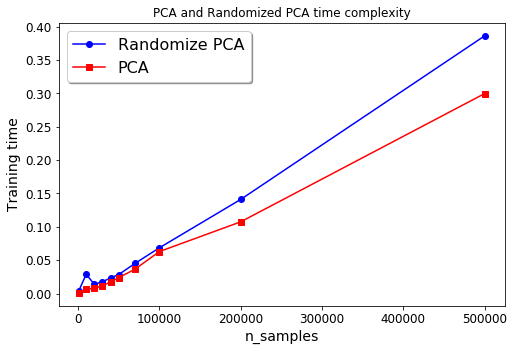

In [44]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000,
         200000, 500000]
for n_samples in sizes:
    x = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    t1 = time.time()
    pca.fit(x)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2)
    t1 = time.time()
    pca.fit(x)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(8, 5.2))
plt.plot(sizes, times_rpca, 'b-o', label='Randomize PCA')
plt.plot(sizes, times_pca, 'r-s', label='PCA')
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left", fontsize=16, shadow=True)
plt.title("PCA and Randomized PCA time complexity")
plt.show()

**Compare their performance on datasets of 2,000 instances with various numbers of features:**

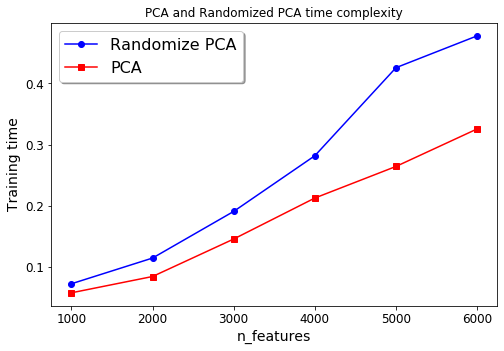

In [46]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, svd_solver='randomized', random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(8, 5.2))
plt.plot(sizes, times_rpca, 'b-o', label='Randomize PCA')
plt.plot(sizes, times_pca, 'r-s', label='PCA')
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left", fontsize=16, shadow=True)
plt.title("PCA and Randomized PCA time complexity")
plt.show()

# 4. Kernel PCA